In [2]:
import pandas as pd
import re
import spacy
import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud

/Users/paigelin/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
fake_news = pd.read_csv('Fake.csv')
real_news = pd.read_csv('True.csv')

print(fake_news.head())
print(real_news.head())

# Check for missing values
print(fake_news.isnull().sum())
print(real_news.isnull().sum())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept t

# Data Preprocessing

In [4]:
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stop words and lemmatize
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc if token.text not in STOP_WORDS and not token.is_punct])
    return text

fake_news['cleaned_text'] = fake_news['title'].apply(preprocess_text)
real_news['cleaned_text'] = real_news['title'].apply(preprocess_text)

print(fake_news[['text', 'cleaned_text']].head())
print(real_news[['text', 'cleaned_text']].head())

                                                text  \
0  Donald Trump just couldn t wish all Americans ...   
1  House Intelligence Committee Chairman Devin Nu...   
2  On Friday, it was revealed that former Milwauk...   
3  On Christmas day, Donald Trump announced that ...   
4  Pope Francis used his annual Christmas Day mes...   

                                        cleaned_text  
0    donald trump send embarrassing new year eve ...  
1    drunk bragging trump staffer start russian c...  
2    sheriff david clarke internet joke threaten ...  
3           trump obsessed obamas code website image  
4    pope francis call donald trump christmas speech  
                                                text  \
0  WASHINGTON (Reuters) - The head of a conservat...   
1  WASHINGTON (Reuters) - Transgender people will...   
2  WASHINGTON (Reuters) - The special counsel inv...   
3  WASHINGTON (Reuters) - Trump campaign adviser ...   
4  SEATTLE/WASHINGTON (Reuters) - President Donal... 

# Perform NER

In [5]:
# Extract NER entities
def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]  # Extract entity text and type
    return entities

# Apply NER to both datasets
fake_news['entities'] = fake_news['cleaned_text'].apply(extract_entities)
real_news['entities'] = real_news['cleaned_text'].apply(extract_entities)

print(fake_news[['cleaned_text', 'entities']].head())
print(real_news[['cleaned_text', 'entities']].head())

                                        cleaned_text  \
0    donald trump send embarrassing new year eve ...   
1    drunk bragging trump staffer start russian c...   
2    sheriff david clarke internet joke threaten ...   
3           trump obsessed obamas code website image   
4    pope francis call donald trump christmas speech   

                             entities  
0            [(donald trump, PERSON)]  
1                   [(russian, NORP)]  
2            [(david clarke, PERSON)]  
3                                  []  
4  [(donald trump christmas, PERSON)]  
                                        cleaned_text  \
0   budget fight loom republicans flip fiscal script   
1  military accept transgender recruit monday pen...   
2       senior republican senator let mr mueller job   
3  fbi russia probe help australian diplomat tipo...   
4   trump want postal service charge amazon shipment   

                                  entities  
0                    [(republicans, NORP)

# Analyze Entity Counts

In [6]:
# Flatten and count entity types
fake_entity_counts = pd.DataFrame([ent[1] for ents in fake_news['entities'] for ent in ents], columns=['Entity_Type']).value_counts()
real_entity_counts = pd.DataFrame([ent[1] for ents in real_news['entities'] for ent in ents], columns=['Entity_Type']).value_counts()

print("Fake News Entity Counts:")
print(fake_entity_counts)

print("Real News Entity Counts:")
print(real_entity_counts)

Fake News Entity Counts:
Entity_Type
PERSON         9744
ORG            5641
NORP           5028
GPE            3738
DATE            779
CARDINAL        501
TIME            154
ORDINAL         106
LOC             104
FAC              48
MONEY            47
PRODUCT          38
LAW              22
LANGUAGE          8
EVENT             8
WORK_OF_ART       5
QUANTITY          4
PERCENT           2
Name: count, dtype: int64
Real News Entity Counts:
Entity_Type
GPE            9251
ORG            6885
NORP           5512
PERSON         4134
DATE            909
CARDINAL        438
LOC             313
LAW             153
TIME             88
FAC              82
ORDINAL          75
PRODUCT          31
LANGUAGE         13
MONEY             9
EVENT             7
WORK_OF_ART       7
QUANTITY          5
PERCENT           3
Name: count, dtype: int64


# Topic Modeling

In [7]:
# Vectorize text for Fake News
fake_vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
fake_vectorized = fake_vectorizer.fit_transform(fake_news['cleaned_text'])

# Vectorize text for Real News
real_vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
real_vectorized = real_vectorizer.fit_transform(real_news['cleaned_text'])

# Apply LDA for Fake News
lda_fake = LatentDirichletAllocation(n_components=5, random_state=42)
lda_fake.fit(fake_vectorized)

# Apply LDA for Real News
lda_real = LatentDirichletAllocation(n_components=5, random_state=42)
lda_real.fit(real_vectorized)

# Display topics for Fake News
fake_words = fake_vectorizer.get_feature_names_out()
print("Fake News Topics:")
for idx, topic in enumerate(lda_fake.components_):
    print(f"Topic {idx}: {[fake_words[i] for i in topic.argsort()[-10:]]}")

# Display topics for Real News
real_words = real_vectorizer.get_feature_names_out()
print("\nReal News Topics:")
for idx, topic in enumerate(lda_real.components_):
    print(f"Topic {idx}: {[real_words[i] for i in topic.argsort()[-10:]]}")


Fake News Topics:
Topic 0: ['house', 'president', 'obamas', 'war', 'attack', 'america', 'white', 'obama', 'video', 'trump']
Topic 1: ['police', 'cop', 'illegal', 'watch', 'man', 'hillary', 'break', 'muslim', 'black', 'video']
Topic 2: ['cnn', 'fbi', 'hillary', 'obama', 'clinton', 'new', 'president', 'watch', 'trump', 'video']
Topic 3: ['republicans', 'president', 'hillary', 'gop', 'obama', 'donald', 'tweet', 'watch', 'video', 'trump']
Topic 4: ['fake', 'obama', 'break', 'new', 'fox', 'clinton', 'hillary', 'news', 'trump', 'video']

Real News Topics:
Topic 0: ['iran', 'brexit', 'deal', 'talk', 'eu', 'china', 'korea', 'trump', 'north', 'say']
Topic 1: ['army', 'right', 'suspect', 'chief', 'protest', 'arrest', 'state', 'attack', 'police', 'kill']
Topic 2: ['pm', 'election', 'party', 'ban', 'new', 'leader', 'rule', 'vote', 'court', 'trump']
Topic 3: ['putin', 'saudi', 'plan', 'syrian', 'tax', 'syria', 'state', 'russia', 'say', 'trump']
Topic 4: ['campaign', 'lawmaker', 'probe', 'say', 'rep

# Generate Word Clouds

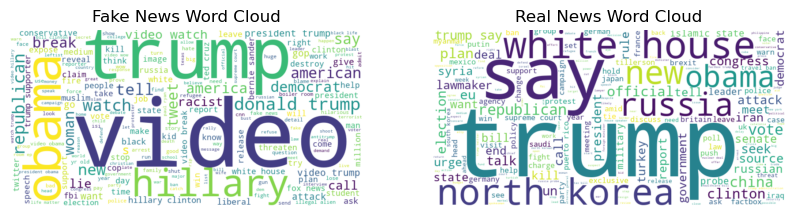

In [8]:
# Combine text for word clouds
fake_text = ' '.join(fake_news['cleaned_text'])
real_text = ' '.join(real_news['cleaned_text'])

# Generate word clouds
fake_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
real_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(real_text)

# Plot word clouds
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News Word Cloud')

plt.subplot(1, 2, 2)
plt.imshow(real_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Real News Word Cloud')

plt.show()

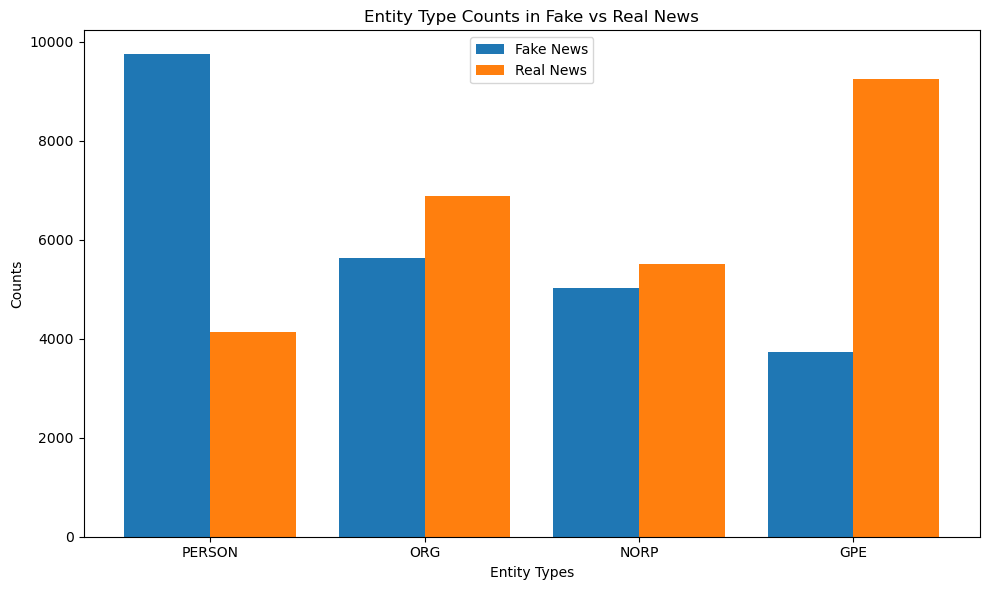

In [10]:
import matplotlib.pyplot as plt

# Data for the chart
entity_types = ['PERSON', 'ORG', 'NORP', 'GPE']
fake_counts = [9744, 5641, 5028, 3738]
real_counts = [4134, 6885, 5512, 9251]

# Plotting the chart
x = range(len(entity_types))
plt.figure(figsize=(10, 6))
plt.bar(x, fake_counts, width=0.4, label='Fake News', align='center')
plt.bar([i + 0.4 for i in x], real_counts, width=0.4, label='Real News', align='center')

# Adding labels and title
plt.xlabel("Entity Types")
plt.ylabel("Counts")
plt.title("Entity Type Counts in Fake vs Real News")
plt.xticks([i + 0.2 for i in x], entity_types)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()
